# Chapter3: 様々な確率分布を想定したベイズ分析

In [4]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize as opt
import scipy.linalg as la
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

,平均,中央値,最頻値,標準偏差,信用区間（下限）,信用区間（上限）,HPD区間（下限）,HPD区間（上限）
$\lambda$,2.901961,2.895427,2.882353,0.23854,2.453271,3.387776,2.440932,3.374032


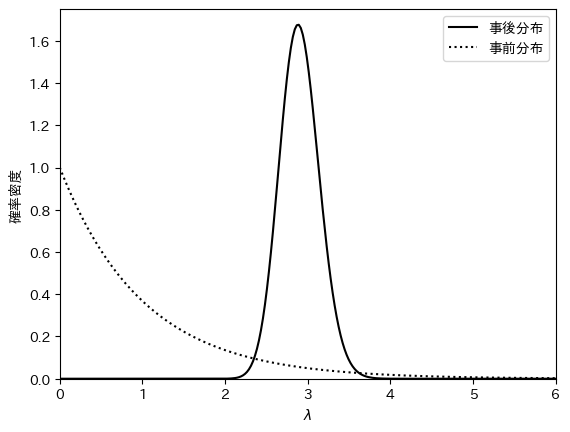

In [5]:
# 3.1
# ガンマ分布のHPD区間の計算
def gamma_hpdi(ci0, alpha, theta, prob):
    def hpdi_conditions(v, a, t, p):
        eq1 = st.gamma.cdf(v[1], a, scale=t) - st.gamma.cdf(v[0], a, scale=t) - p
        eq2 = st.gamma.pdf(v[1], a, scale=t) - st.gamma.pdf(v[0], a, scale=t)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, theta, prob)).x

# ポアソン分布のパラメータの事後統計量の計算
def poisson_stats(data, a0, b0, prob):
    n = data.size
    a_star = data.sum() + a0
    b_star = n + b0
    theta_star = 1.0 / b_star
    mean_lam = st.gamma.mean(a_star, scale=theta_star)
    median_lam = st.gamma.median(a_star, scale=theta_star)
    mode_lam = (a_star - 1.0) * theta_star
    sd_lam = st.gamma.std(a_star, scale=theta_star)
    ci_lam = st.gamma.interval(prob, a_star, scale=theta_star)
    hpdi_lam = gamma_hpdi(ci_lam, a_star, theta_star, prob)
    stats = np.hstack((mean_lam, median_lam, mode_lam, sd_lam, ci_lam, hpdi_lam)).reshape((1, 8))
    stats_string = ['平均', '中央値', '最頻値', '標準偏差', 
                    '信用区間（下限）', '信用区間（上限）', 'HPD区間（下限）', 'HPD区間（上限）']
    param_string = ['$\\lambda$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, a_star, b_star

# ポアソン分布からのデータの生成
lam = 3.0
n = 50
np.random.seed(99)
data = st.poisson.rvs(lam, size=n)

# 事後統計量の計算
a0 = 1.0
b0 = 1.0
prob = 0.95
results, a_star, b_star = poisson_stats(data, a0, b0, prob)
display(results)

# 事後分布のグラフの作成
fig = plt.figure(num=1, facecolor='w')
x = np.linspace(0, 6, 250)
plt.plot(x, st.gamma.pdf(x, a_star, scale=1.0/b_star), 'k-', label='事後分布')
plt.plot(x, st.gamma.pdf(x, a0, scale=1.0/b0), 'k:', label='事前分布')
plt.xlim(0, 6)
plt.ylim(0, 1.75)
plt.xlabel('$\\lambda$')
plt.ylabel('確率密度')
plt.legend(loc='best')
plt.show()

,平均,中央値,最頻値,標準偏差,信用区間（下限）,信用区間（上限）,HPD区間（下限）,HPD区間（上限）
平均 $\mu$,1.004282,1.004282,1.004282,0.271394,0.470378,1.538187,0.470378,1.538187
分散 $\sigma^2$,3.697454,3.606622,3.437984,0.732205,2.532488,5.383935,2.402354,5.165040


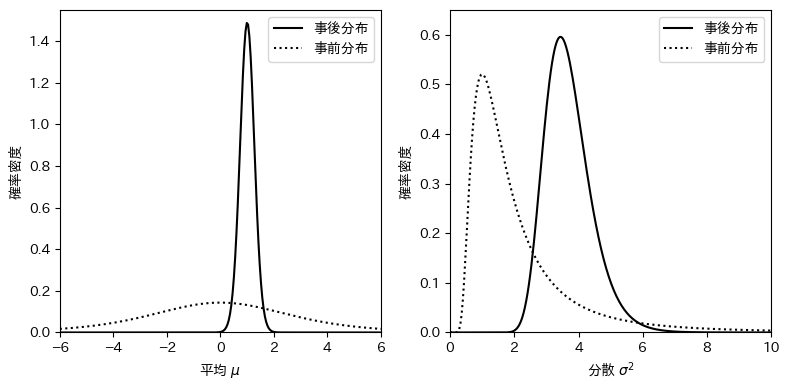

In [6]:
# 3.2
# 正規分布のヘイインと分散に関するベイズ推論
# 逆ガンマ分布のHPD区間の計算
def invgamma_hpdi(ci0, alpha, beta, prob):
    def hpdi_conditions(v, a, b, p):
        eq1 = st.invgamma.cdf(v[1], a, scale=b) - st.invgamma.cdf(v[0], a, scale=b) - p
        eq2 = st.invgamma.pdf(v[1], a, scale=b) - st.invgamma.pdf(v[0], a, scale=b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x

# 正規分布の平均と分散お事後統計量の計算
def gaussian_stats(data, mu0, n0, nu0, lam0, prob):
    n = data.size
    mean_data = data.mean()
    ssd_data = n * data.var()
    n_star = n + n0
    mu_star = (n*mean_data + n0*mu0) / n_star
    nu_star = n + nu0
    lam_star = ssd_data + n*n0/n_star * (mu0 - mean_data)**2 + lam0
    tau_star = np.sqrt(lam_star / nu_star / n_star)
    sd_mu = st.t.std(nu_star, loc=mu_star, scale=tau_star)
    ci_mu = st.t.interval(prob, nu_star, loc=mu_star, scale=tau_star)
    mean_sigma2 = st.invgamma.mean(0.5*nu_star, scale=0.5*lam_star)
    mode_sigma2 = lam_star / (nu_star+2.0)
    median_sigma2 = st.invgamma.median(0.5*nu_star, scale=0.5*lam_star)
    sd_sigma2 = st.invgamma.std(0.5*nu_star, scale=0.5*lam_star)
    ci_sigma2 = st.invgamma.interval(prob, 0.5*nu_star, scale=0.5*lam_star)
    hpdi_sigma2 = invgamma_hpdi(ci_sigma2, 0.5*nu_star, 0.5*lam_star, prob)
    stats_mu = np.hstack((mu_star, mu_star, mu_star, sd_mu, ci_mu, ci_mu))
    stats_sigma2 = np.hstack((mean_sigma2, median_sigma2, mode_sigma2, 
                               sd_sigma2, ci_sigma2, hpdi_sigma2))
    stats = np.vstack((stats_mu, stats_sigma2))
    stats_string = ['平均', '中央値', '最頻値', '標準偏差', 
                    '信用区間（下限）', '信用区間（上限）', 'HPD区間（下限）', 'HPD区間（上限）']
    param_string = ['平均 $\\mu$', '分散 $\\sigma^2$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, mu_star, tau_star, nu_star, lam_star

# 正規分布からのデータの生成
mu = 1.0
sigma = 2.0
n = 50
np.random.seed(99)
data = st.norm.rvs(loc=mu, scale=sigma, size=n)

# 事後統計量の計算
mu0 = 0.0
n0 = 0.2
nu0 = 5.0
lam0 = 7.0
tau0 = np.sqrt(lam0 / nu0 / n0)
prob = 0.95
results, mu_star, tau_star, nu_star, lam_star = gaussian_stats(data, mu0, n0, nu0, lam0, prob)
display(results)

# 事後分布のグラフの作成
fig, ax = plt.subplots(1, 2, num=1, figsize=(8, 4), facecolor='w')
# 平均の周辺事後分布のグラフの作成
x1 = np.linspace(-6, 6, 250)
ax[0].plot(x1, st.t.pdf(x1, nu_star, loc=mu_star, scale=tau_star), 'k-', label='事後分布')
ax[0].plot(x1, st.t.pdf(x1, nu0, loc=mu0, scale=tau0), 'k:', label='事前分布')
ax[0].set_xlim(-6, 6)
ax[0].set_ylim(0, 1.55)
ax[0].set_xlabel('平均 $\\mu$')
ax[0].set_ylabel('確率密度')
ax[0].legend(loc='best')
# 分散の周辺事後分布のグラフを作成
x2 = np.linspace(0, 10, 250)
ax[1].plot(x2, st.invgamma.pdf(x2, 0.5*nu_star, scale=0.5*lam_star), 'k-', label='事後分布')
ax[1].plot(x2, st.invgamma.pdf(x2, 0.5*nu0, scale=0.5*lam0), 'k:', label='事前分布')
ax[1].set_xlim(0, 10)
ax[1].set_ylim(0, 0.65)
ax[1].set_xlabel('分散 $\\sigma^2$')
ax[1].set_ylabel('確率密度')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

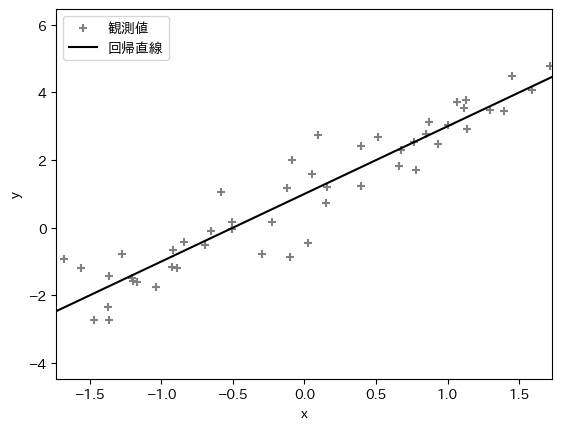

,平均,中央値,最頻値,標準偏差,信用区間（下限）,信用区間（上限）,HPD区間（下限）,HPD区間（上限）
切片 $\alpha$,0.999026,0.999026,0.999026,0.108231,0.786106,1.211946,0.786106,1.211946
傾き $\beta$,2.003237,2.003237,2.003237,0.111298,1.784285,2.222190,1.784285,2.222190
分散 $\sigma^2$,0.587232,0.572806,0.546022,0.116289,0.402211,0.855079,0.381543,0.820314


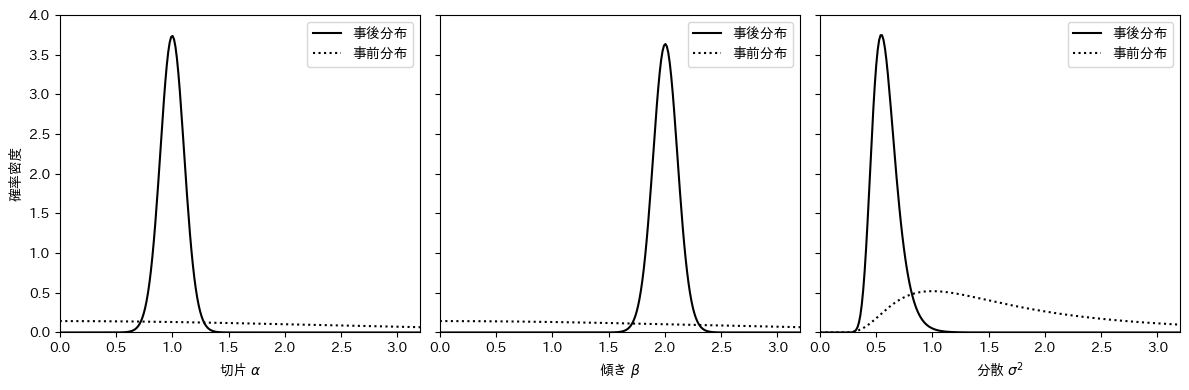

In [7]:
# 3.3
# 回帰モデルの係数と誤差項の分散に関するベイズ推論
# 逆カンマ分布のHPD区間の計算
def invgamma_hpdi(ci0, alpha, beta, prob):
    def hpdi_conditions(v, a, b, p):
        eq1 = st.invgamma.cdf(v[1], a, scale=b) - st.invgamma.cdf(v[0], a, scale=b) - p
        eq2 = st.invgamma.pdf(v[1], a, scale=b) - st.invgamma.pdf(v[0], a, scale=b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x

# 回帰モデルの係数と誤差項の分散の事後統計量の計算
def regression_stats(y, X, b0, A0, nu0, lam0, prob):
    XX = X.T.dot(X)
    Xy = X.T.dot(y)
    b_ols = la.solve(XX, Xy)
    A_star = XX + A0
    b_star = la.solve(A_star, Xy+A0.dot(b0))
    C_star = la.inv(la.inv(XX) + la.inv(A0))
    nu_star = y.size + nu0
    lam_star = np.square(y-X.dot(b_ols)).sum() \
                + (b0-b_ols).T.dot(C_star.dot(b0-b_ols)) + lam0
    h_star = np.sqrt(lam_star / nu_star * np.diag(la.inv(A_star)))
    sd_b = st.t.std(nu_star, loc=b_star, scale=h_star)
    ci_b = np.vstack(st.t.interval(prob, nu_star, loc=b_star, scale=h_star))
    hpdi_b = ci_b
    stats_b = np.vstack((b_star, b_star, b_star, sd_b, ci_b, hpdi_b)).T
    mean_sigma2 = st.invgamma.mean(0.5*nu_star, scale=0.5*lam_star)
    median_sigma2 = st.invgamma.median(0.5*nu_star, scale=0.5*lam_star)
    mode_sigma2 = lam_star / (nu_star + 2.0)
    sd_sigma2 = st.invgamma.std(0.5*nu_star, scale=0.5*lam_star)
    ci_sigma2 = st.invgamma.interval(prob, 0.5*nu_star, scale=0.5*lam_star)
    hpdi_sigma2 = invgamma_hpdi(ci_sigma2, 0.5*nu_star, 0.5*lam_star, prob)
    stats_sigma2 = np.hstack((mean_sigma2, median_sigma2, mode_sigma2, 
                              sd_sigma2, ci_sigma2, hpdi_sigma2))
    stats = np.vstack((stats_b, stats_sigma2))
    stats_string = ['平均', '中央値', '最頻値', '標準偏差', 
                    '信用区間（下限）', '信用区間（上限）', 'HPD区間（下限）', 'HPD区間（上限）']
    param_string = ['切片 $\\alpha$', '傾き $\\beta$', '分散 $\\sigma^2$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, b_star, h_star, nu_star, lam_star

# 回帰モデルからのデータの生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x + u
X = np.stack((np.ones(n), x), axis=1)
fig1 = plt.figure(num=1, facecolor='w')
plt.scatter(x, y, color='0.5', marker='+', label='観測値')
x_range = (-np.sqrt(3.0), np.sqrt(3.0))
y_range = (1.0 - 2.0*np.sqrt(3.0), 1.0 + 2.0*np.sqrt(3.0))
plt.plot(x_range, y_range, 'k-', label='回帰直線')
plt.xlim(x_range)
plt.ylim(y_range[0] - 2.0, y_range[1] + 2.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

# 事後統計量の計算
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
prob = 0.95
results, b_star, h, nu_star, lam_star = regression_stats(y, X, b0, A0, nu0, lam0, prob)
display(results)

# 事後分布のグラフの作成
labels = ['切片 $\\alpha$', '傾き $\\beta$', '分散 $\\sigma^2$']
fig2, ax2 = plt.subplots(1, 3, sharey='all', sharex='all', num=2, figsize=(12, 4), facecolor='w')
x = np.linspace(0, 3.2, 250)
ax2[0].set_xlim(0, 3.2)
ax2[0].set_ylim(0, 4)
ax2[0].set_ylabel('確率密度')
for idx in range(3):
    if idx < 2:
        posterior = st.t.pdf(x, nu_star, loc=b_star[idx], scale=h[idx])
        prior = st.t.pdf(x, nu0, loc=b0[idx], scale=h0[idx])
    else:
        posterior = st.invgamma.pdf(x, 0.5*nu_star, scale=0.5*lam_star)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
    ax2[idx].plot(x, posterior, 'k-', label='事後分布')
    ax2[idx].plot(x, prior, 'k:', label='事前分布')
    ax2[idx].set_xlabel(labels[idx])
    ax2[idx].legend(loc='best')
plt.tight_layout()
plt.show()